In [1]:
# Data processing
import pandas as pd
import numpy as np

# Model and performance evaluation
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import precision_recall_fscore_support as score 
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Hyperparameter tuning
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
# from hyperopt import tpe, STATUS_OK, Trials, hp, fmin, STATUS_OK, space_eval

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
# import the data
data = pd.read_csv('/Users/danherman/Desktop/oud_treatment_outcome/data/clean_data/sep6.csv')

In [3]:
# set the feature and target variable
X = data.drop(columns='outcome')
y = data.outcome

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

###  Before executing grid search alogrithms, a benchmark model has to be fitted

In [4]:
# Initiate XGBoost Classifier
xgbc0 = XGBClassifier()

# Print default setting
xgbc0.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [5]:
# Train the model
xgbc0 = XGBClassifier(seed=0).fit(X_train,y_train)

# Make prediction
xgbc0_predict = xgbc0.predict(X_test)

# Get predicted probability
xgbc0_predict_prob = xgbc0.predict_proba(X_test)[:,1]

In [7]:
# Get performance metrics
precision, recall, fscore, support = score(y_test, xgbc0_predict)

# Print result
print(f'The recall value for the baseline xgboost model is {recall[1]:.4f}')

The recall value for the baseline xgboost model is 0.7623


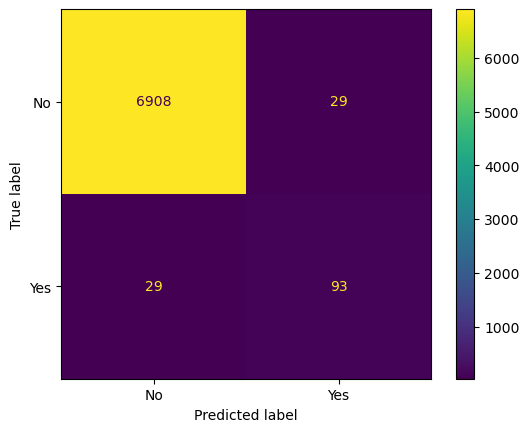

In [8]:
# show confusion matrix display
confusion_matrix = confusion_matrix(y_test, xgbc0_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=['No', 'Yes'])
disp.plot();

### We wil now take a brute force approach to grid search to find ideal params to optimize the model
We will keep the grid search space relatively small to finish in a reasonable timeframe 

In [9]:
# Define the search space
param_grid = { 
    # Percentage of columns to be randomly samples for each tree.
    "colsample_bytree": [ 0.3, 0.5 , 0.8 ],
    # reg_alpha provides l1 regularization to the weight, higher values result in more conservative models
    "reg_alpha": [0, 0.5, 1, 5],
    # reg_lambda provides l2 regularization to the weight, higher values result in more conservative models
    "reg_lambda": [0, 0.5, 1, 5]
    }
# Set up score
scoring = ['recall']
# Set up the k-fold cross-validation
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

In [10]:
# Define grid search
grid_search = GridSearchCV(estimator=xgbc0, 
                           param_grid=param_grid, 
                           scoring=scoring, 
                           refit='recall', 
                           n_jobs=8, 
                           cv=kfold, 
                           verbose=5)

# Fit grid search
grid_result = grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV 2/3] END colsample_bytree=0.3, reg_alpha=0, reg_lambda=0; recall: (test=0.787) total time=   2.5s
[CV 2/3] END colsample_bytree=0.3, reg_alpha=0, reg_lambda=0.5; recall: (test=0.831) total time=   2.4s
[CV 1/3] END colsample_bytree=0.3, reg_alpha=0, reg_lambda=0.5; recall: (test=0.798) total time=   2.4s
[CV 1/3] END colsample_bytree=0.3, reg_alpha=0, reg_lambda=1; recall: (test=0.809) total time=   2.4s
[CV 3/3] END colsample_bytree=0.3, reg_alpha=0, reg_lambda=0.5; recall: (test=0.753) total time=   2.4s
[CV 2/3] END colsample_bytree=0.3, reg_alpha=0, reg_lambda=1; recall: (test=0.865) total time=   2.5s
[CV 1/3] END colsample_bytree=0.3, reg_alpha=0, reg_lambda=0; recall: (test=0.798) total time=   2.6s
[CV 3/3] END colsample_bytree=0.3, reg_alpha=0, reg_lambda=0; recall: (test=0.742) total time=   2.7s
[CV 1/3] END colsample_bytree=0.3, reg_alpha=0, reg_lambda=5; recall: (test=0.843) total time=   2.2s
[CV 2/3] END c

In [11]:
# Print grid search summary
grid_result

# Print the best score and the corresponding hyperparameters
print(f'The best score is {grid_result.best_score_:.4f}')
print('The best score standard deviation is', round(grid_result.cv_results_['std_test_recall'][grid_result.best_index_], 4))
print(f'The best hyperparameters are {grid_result.best_params_}')

The best score is 0.8989
The best score standard deviation is 0.0
The best hyperparameters are {'colsample_bytree': 0.3, 'reg_alpha': 5, 'reg_lambda': 0.5}


In [12]:
# Make prediction using the best model
grid_predict = grid_search.predict(X_test)

# Get predicted probabilities
grid_predict_prob = grid_search.predict_proba(X_test)[:,1]

# Get performance metrics
precision, recall, fscore, support = score(y_test, grid_predict)

# Print result
print(f'The recall value for the xgboost grid search is {recall[1]:.4f}')

The recall value for the xgboost grid search is 0.8033


Model improvemen of 10% accuracy after gridsearch param tuning

### Random Search for XGBoost
In step 7, we are using a random search for XGBoost hyperparameter tuning. Since random search randomly picks a fixed number of hyperparameter combinations, we can afford to try more hyperparameters and more values. Therefore, we added three more parameters to the search space.

In [13]:
# Define the search space
param_grid = { 
    # Learning rate shrinks the weights to make the boosting process more conservative
    "learning_rate": [0.0001,0.001, 0.01, 0.1, 1] ,
    # Maximum depth of the tree, increasing it increases the model complexity.
    "max_depth": range(3,21,3),
    # Gamma specifies the minimum loss reduction required to make a split.
    "gamma": [i/10.0 for i in range(0,5)],
    # Percentage of columns to be randomly samples for each tree.
    "colsample_bytree": [i/10.0 for i in range(3,10)],
    # reg_alpha provides l1 regularization to the weight, higher values result in more conservative models
    "reg_alpha": [1e-5, 1e-2, 0.1, 1, 10, 100],
    # reg_lambda provides l2 regularization to the weight, higher values result in more conservative models
    "reg_lambda": [1e-5, 1e-2, 0.1, 1, 10, 100]}
# Set up score
scoring = ['recall']
# Set up the k-fold cross-validation
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

In [14]:
# Define random search
random_search = RandomizedSearchCV(estimator=xgbc0, 
                           param_distributions=param_grid, 
                           n_iter=48,
                           scoring=scoring, 
                           refit='recall', 
                           n_jobs=8, 
                           cv=kfold, 
                           verbose=5)
# Fit grid search
random_result = random_search.fit(X_train, y_train)




Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV 3/3] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.001, max_depth=6, reg_alpha=0.1, reg_lambda=100; recall: (test=0.000) total time=   1.3s
[CV 2/3] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.001, max_depth=6, reg_alpha=0.1, reg_lambda=100; recall: (test=0.000) total time=   1.3s
[CV 1/3] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.001, max_depth=6, reg_alpha=0.1, reg_lambda=100; recall: (test=0.000) total time=   1.4s
[CV 2/3] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.0001, max_depth=3, reg_alpha=100, reg_lambda=1e-05; recall: (test=0.000) total time=   2.4s
[CV 3/3] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.0001, max_depth=3, reg_alpha=100, reg_lambda=1e-05; recall: (test=0.000) total time=   2.5s
[CV 1/3] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.0001, max_depth=3, reg_alpha=100, reg_lambda=1e-05; recall: (test=0.000) total time=   2.8s
[CV 2/3] END colsample_

In [15]:
# Print grid search summary
random_result
# Print the best score and the corresponding hyperparameters
print(f'The best score is {random_result.best_score_:.4f}')
print('The best score standard deviation is', round(random_result.cv_results_['std_test_recall'][random_result.best_index_], 4))
print(f'The best hyperparameters are {random_result.best_params_}')

The best score is 0.9139
The best score standard deviation is 0.0106
The best hyperparameters are {'reg_lambda': 1e-05, 'reg_alpha': 1, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.9}


In [22]:
# Make prediction using the best model
random_predict = random_search.predict(X_test)

# Get predicted probabilities
random_predict_prob = random_search.predict_proba(X_test)[:,1]

# Get performance metrics
precision, recall, fscore, support = score(y_test, random_predict)

# Print result
print(f'The recall value for the xgboost random search is {recall[1]:.4f}')

The recall value for the xgboost random search is 0.8279


In [23]:
# Initiate XGBoost Classifier
xgbc1 = XGBClassifier(
    colsample_bytree=0.8,
    gamma=0.0,
    learning_rate=0.1,
    max_depth=3,
    reg_alpha=0.1,
    reg_lambda=1e-05,
    seed=0
).fit(X_train,y_train)

# Make prediction
xgbc1_predict = xgbc1.predict(X_test)

# Get predicted probability
xgbc1_predict_prob = xgbc1.predict_proba(X_test)[:,1]

# Get performance metrics
precision, recall, fscore, support = score(y_test, xgbc1_predict)

# Print result
print(f'The recall value for the xgboost optimization is {recall[1]:.4f}')

The recall value for the xgboost optimization is 0.8115


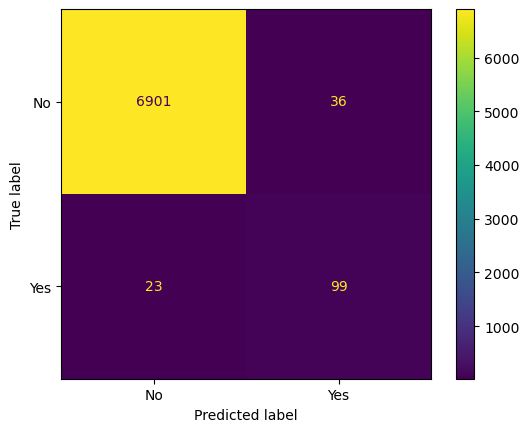

In [31]:
# show confusion matrix display (rebind new object)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, xgbc1_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
disp.plot();
